# SCS 3546: Deep Learning
> Term Project - Forest fire monitoring using Deep Neural Network

### Name & student number:

<pre> Sigao Li </pre>

<pre> X503624 </pre>

# Part 1: Environment Setup and Data Preprocessing

This part includes setting up the environment, handling GPU configuration, removing corrupted images, balancing the dataset, and setting up data generators with augmentation.

In [1]:
import os
import random
import time
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from PIL import Image, ImageFile
from zipfile import ZipFile
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, 
                                     GlobalAveragePooling2D, Add, Dense, Dropout, Flatten, Concatenate)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from transformers import TFViTForImageClassification

# Set PIL to ignore images that are truncated
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
# GPU Configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Specify that all operations should be performed on the GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU found. Using CPU instead.")

No GPU found. Using CPU instead.


In [3]:
# Function to remove corrupted image files
def remove_corrupted_images(directory):
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(subdir, file)
            try:
                # Open the image file and verify it's not corrupted
                with Image.open(file_path) as img:
                    img.verify()
            except (IOError, SyntaxError) as e:
                print('Corrupted file found and removed:', file_path)
                os.remove(file_path)

# Define the path to the compressed dataset and the directory for the balanced dataset
compressed_dataset_path = 'archive.zip' #Data Source: https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset/data
balanced_dataset_dir = 'Balanced Data'

# Extract the compressed dataset
with ZipFile(compressed_dataset_path, 'r') as zip_ref:
    zip_ref.extractall(balanced_dataset_dir)

# Call the function to remove corrupted images
remove_corrupted_images(balanced_dataset_dir)

# Function to randomly delete files until the desired count is reached
def randomly_delete_files(directory, target_count):
    files = os.listdir(directory)
    random.shuffle(files)
    num_files_to_delete = len(files) - target_count
    for i in range(num_files_to_delete):
        os.remove(os.path.join(directory, files[i]))

# Define the target numbers for each class
targets = {
    'train': {'wildfire': 7000, 'nowildfire': 7000},
    'valid': {'wildfire': 1500, 'nowildfire': 1500},
    'test': {'wildfire': 1500, 'nowildfire': 1500}
}

# Balance the dataset
for phase in ['train', 'valid', 'test']:
    for class_name in ['wildfire', 'nowildfire']:
        class_dir = os.path.join(balanced_dataset_dir, phase, class_name)
        randomly_delete_files(class_dir, targets[phase][class_name])

print("Corrupted image files have been removed and the dataset has been balanced.")
print("The balanced dataset is stored in the directory:", balanced_dataset_dir)

Corrupted image files have been removed and the dataset has been balanced.
The balanced dataset is stored in the directory: Balanced Data


In [4]:
# Define the paths to the training, validation, and testing directories
train_dir = os.path.join(balanced_dataset_dir, 'train')
valid_dir = os.path.join(balanced_dataset_dir, 'valid')
test_dir = os.path.join(balanced_dataset_dir, 'test')

# Set up the ImageDataGenerator for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,       # Random rotations
    width_shift_range=0.2,   # Random horizontal shifts
    height_shift_range=0.2,  # Random vertical shifts
    shear_range=0.2,         # Random shears
    zoom_range=0.2,          # Random zooms
    horizontal_flip=True,    # Random horizontal flips
    fill_mode='nearest'      # Strategy for filling in newly created pixels
)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

image_size = (224, 224)
batch_size = 32

# Create data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

print("Data preprocessing is set up.")

Found 14000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.
Found 3000 images belonging to 2 classes.
Data preprocessing is set up.


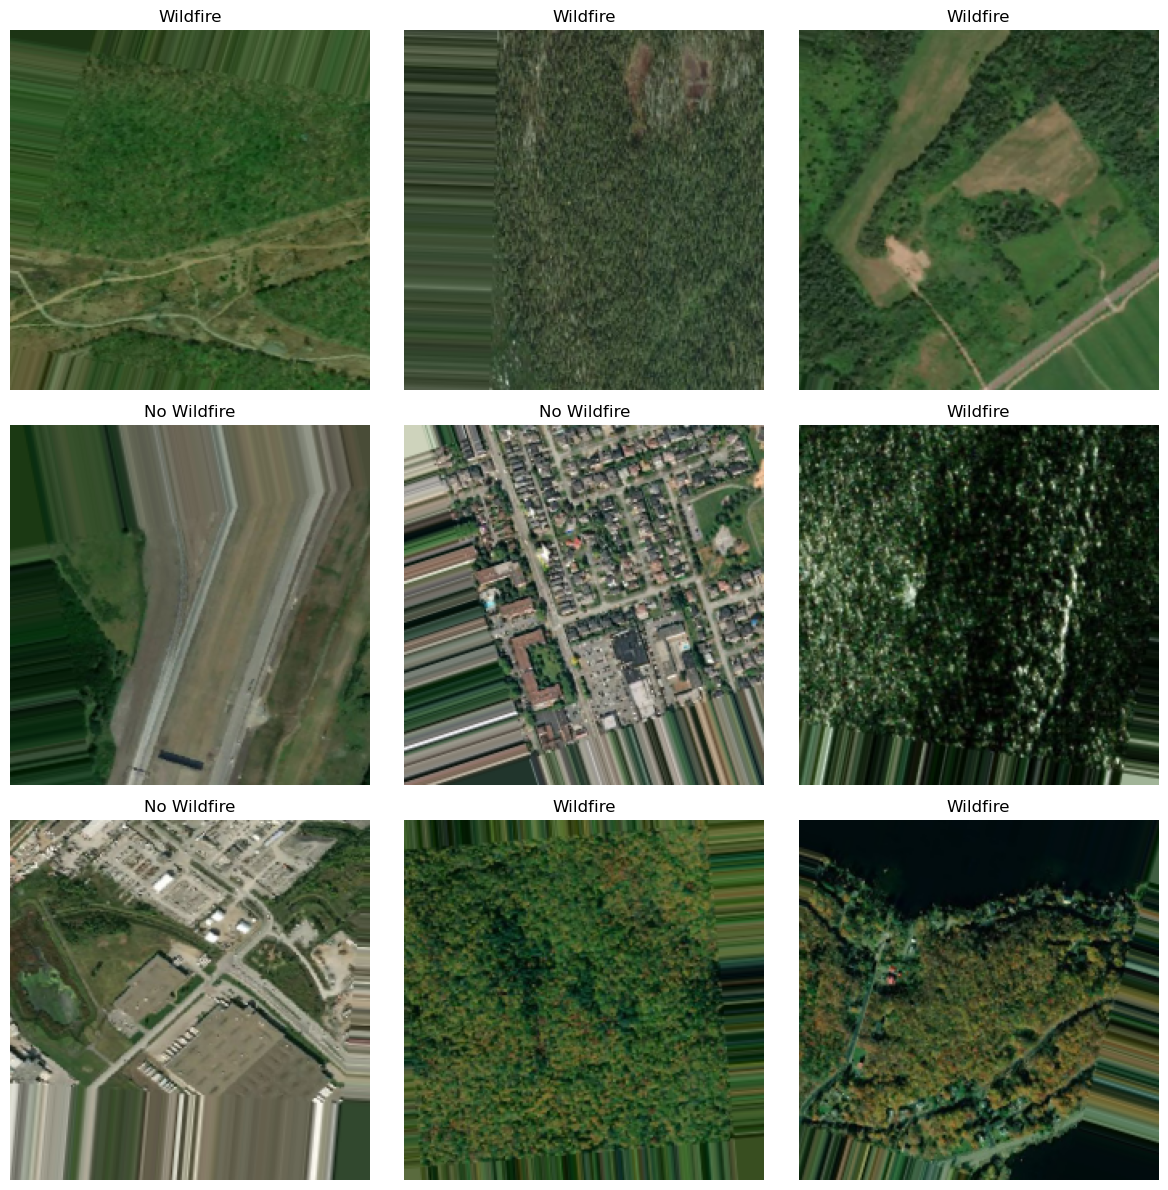

In [5]:
# Display Sample Training Images
def display_sample_images(generator, num_images=9):
    x, y = next(generator)  # Get a batch of images
    plt.figure(figsize=(12, 12))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x[i])
        plt.title('Wildfire' if y[i] else 'No Wildfire')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_sample_images(train_generator)

# Part 2: Model Definition and Compilation

This section includes the definition of your advanced CNN model with residual blocks and its compilation. Also add a function to visualize the model architecture.

In [6]:
def conv_block(inputs, filters, kernel_size, strides=(1, 1), activation='relu', name=None):
    """A convolutional block with Batch Normalization and Activation."""
    x = Conv2D(filters, kernel_size, strides=strides, padding='same', use_bias=False, name=name+'_conv')(inputs)
    x = BatchNormalization(name=name+'_bn')(x)
    x = Activation(activation, name=name+'_activation')(x)
    return x

def residual_block(inputs, filters, kernel_size, block_name):
    """A residual block with two convolutional blocks and a skip connection."""
    x = conv_block(inputs, filters, kernel_size, name=block_name+'_conv_block1')
    x = Conv2D(filters, kernel_size, padding='same', use_bias=False, name=block_name+'_conv_block2_conv')(x)
    x = BatchNormalization(name=block_name+'_conv_block2_bn')(x)

    # Skip connection
    shortcut = Conv2D(filters, (1, 1), padding='same', use_bias=False, name=block_name+'_shortcut_conv')(inputs)
    shortcut = BatchNormalization(name=block_name+'_shortcut_bn')(shortcut)

    x = Add(name=block_name+'_add')([x, shortcut])
    x = Activation('relu', name=block_name+'_out_activation')(x)
    return x

# Model creation function with more filters and an additional residual block
def create_optimized_model(input_shape):
    inputs = Input(shape=input_shape)
    
    x = conv_block(inputs, 32, (3, 3), strides=(2, 2), name='initial_conv')
    x = residual_block(x, 64, (3, 3), block_name='res_block1')
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    
    # New residual block with more filters
    x = residual_block(x, 128, (3, 3), block_name='res_block2')
    x = residual_block(x, 256, (3, 3), block_name='res_block3')  # Additional block
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Multi-scale feature concatenation
    scale_1 = GlobalAveragePooling2D()(x)
    scale_2 = GlobalAveragePooling2D()(MaxPooling2D((2, 2))(x))
    x = Concatenate()([scale_1, scale_2])
    
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    return model

# Create the model
model = create_optimized_model((224, 224, 3))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 initial_conv_conv (Conv2D)  (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 initial_conv_bn (BatchNorm  (None, 112, 112, 32)         128       ['initial_conv_conv[0][0]']   
 alization)                                                                                       
                                                                                                  
 initial_conv_activation (A  (None, 112, 112, 32)         0         ['initial_conv_bn[0][0]'

 (BatchNormalization)                                               0][0]']                       
                                                                                                  
 res_block3_conv_block1_act  (None, 56, 56, 256)          0         ['res_block3_conv_block1_bn[0]
 ivation (Activation)                                               [0]']                         
                                                                                                  
 res_block3_conv_block2_con  (None, 56, 56, 256)          589824    ['res_block3_conv_block1_activ
 v (Conv2D)                                                         ation[0][0]']                 
                                                                                                  
 res_block3_shortcut_conv (  (None, 56, 56, 256)          32768     ['res_block2_out_activation[0]
 Conv2D)                                                            [0]']                         
          

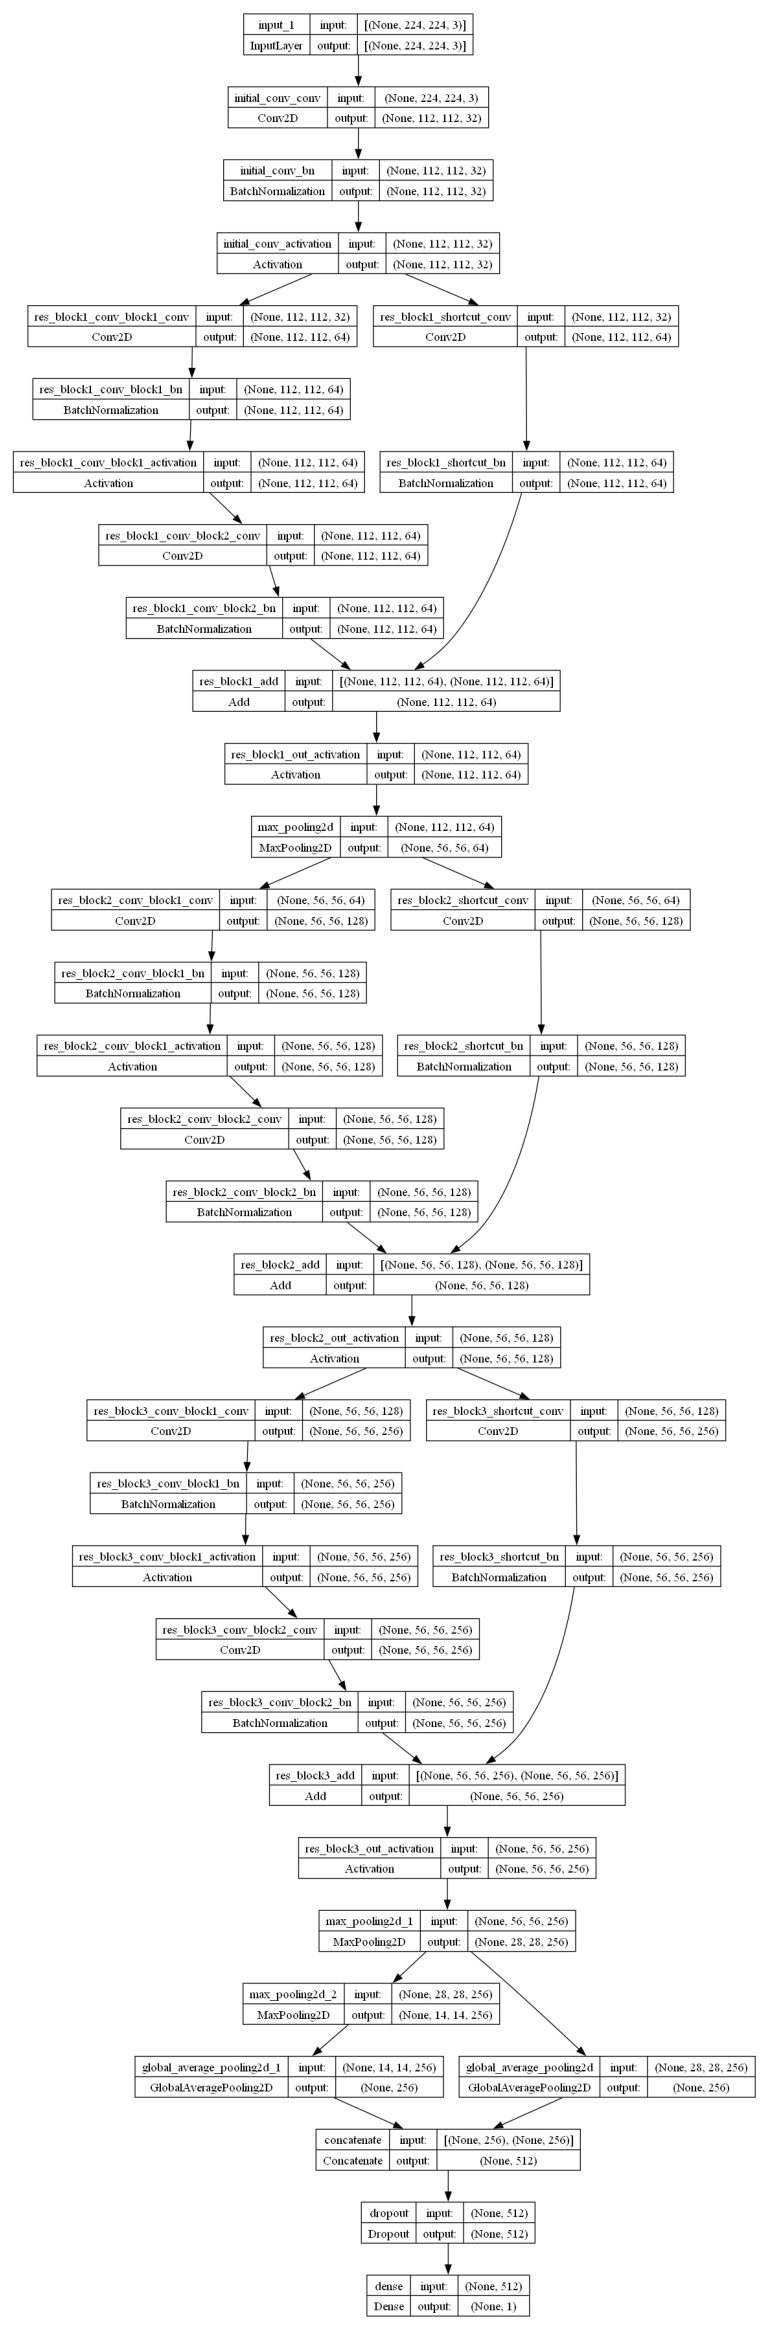

Model defined and compiled.


In [7]:
# Visualize the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

image_path = 'model_architecture.png'

# Load and display the image
img = mpimg.imread(image_path)
plt.figure(figsize=(30, 30))
plt.imshow(img)
plt.axis('off')
plt.show()

print("Model defined and compiled.")

# Part 3: Training the Model

Train the model and implement a function to visualize the training history (accuracy and loss over epochs).

In [8]:
# Function to plot the training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

Epoch 1/30


437/437 [==============================] - ETA: 0s - loss: 0.2353 - accuracy: 0.9168
Epoch 1: val_loss improved from inf to 1.02611, saving model to best_model.h5
437/437 [==============================] - 366s 832ms/step - loss: 0.2353 - accuracy: 0.9168 - val_loss: 1.0261 - val_accuracy: 0.6394
Epoch 2/30


C:\Users\Sigao Li\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


437/437 [==============================] - ETA: 0s - loss: 0.1710 - accuracy: 0.9364
Epoch 2: val_loss improved from 1.02611 to 0.12141, saving model to best_model.h5
437/437 [==============================] - 359s 820ms/step - loss: 0.1710 - accuracy: 0.9364 - val_loss: 0.1214 - val_accuracy: 0.9580
Epoch 3/30
437/437 [==============================] - ETA: 0s - loss: 0.1603 - accuracy: 0.9403
Epoch 3: val_loss did not improve from 0.12141
437/437 [==============================] - 356s 814ms/step - loss: 0.1603 - accuracy: 0.9403 - val_loss: 1.6387 - val_accuracy: 0.6062
Epoch 4/30
437/437 [==============================] - ETA: 0s - loss: 0.1522 - accuracy: 0.9454
Epoch 4: val_loss did not improve from 0.12141
437/437 [==============================] - 358s 821ms/step - loss: 0.1522 - accuracy: 0.9454 - val_loss: 0.3188 - val_accuracy: 0.9073
Epoch 5/30
437/437 [==============================] - ETA: 0s - loss: 0.1446 - accuracy: 0.9482
Epoch 5: val_loss improved from 0.12141 to 0.1

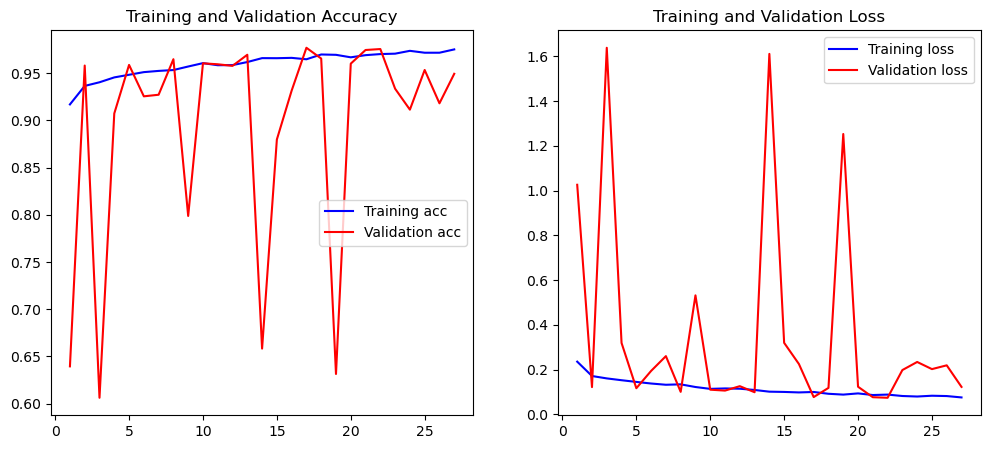

Total training time: 9726.77 seconds


In [9]:
# Define the number of epochs to train for
epochs = 30

# Define the callbacks
# EarlyStopping to stop training if validation loss does not improve
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# ModelCheckpoint to save the model after every epoch
checkpoint = ModelCheckpoint('best_model.h5', verbose=1, save_best_only=True)

start_time = time.time()

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    callbacks=[early_stopping, checkpoint],
    verbose=1
)
end_time = time.time()
print("Training complete.")

# Plot training history
plot_training_history(history)

# Print out the training time
total_training_time = end_time - start_time
print(f"Total training time: {total_training_time:.2f} seconds")

# Part 4: Model Evaluation and Visualization

Evaluate the model on the test set and visualize the results using a confusion matrix and a classification report.

93/93 [==============================] - 22s 233ms/step - loss: 0.0582 - accuracy: 0.9825
Test accuracy: 98.25%
Test loss: 0.05820534750819206
1/1 [==============================] - 0s 191ms/step


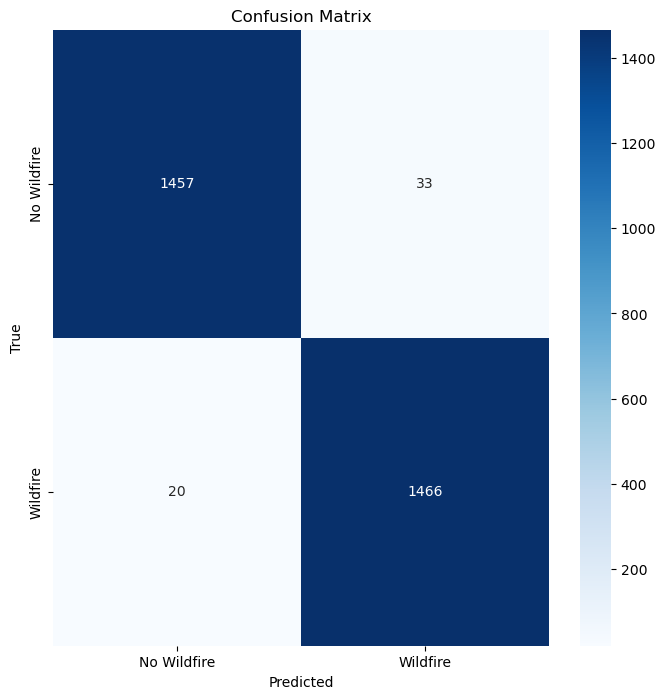

              precision    recall  f1-score   support

 No Wildfire       0.99      0.98      0.98      1490
    Wildfire       0.98      0.99      0.98      1486

    accuracy                           0.98      2976
   macro avg       0.98      0.98      0.98      2976
weighted avg       0.98      0.98      0.98      2976



In [10]:
# Function to evaluate the model and visualize its performance
def evaluate_and_visualize_model(model, generator):
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(generator, steps=generator.samples // generator.batch_size)
    print(f"Test accuracy: {test_accuracy*100:.2f}%")
    print(f"Test loss: {test_loss}")

    # Collecting predictions and true labels
    y_true = []
    y_pred_classes = []
    for _ in range(generator.samples // generator.batch_size):
        x, y = next(generator)
        y_true.extend(y)
        y_pred = model.predict(x)
        y_pred_classes.extend(y_pred.ravel())

    y_true = np.array(y_true)
    y_pred_classes = np.where(np.array(y_pred_classes) > 0.5, 1, 0)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Wildfire', 'Wildfire'], yticklabels=['No Wildfire', 'Wildfire'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print(classification_report(y_true, y_pred_classes, target_names=['No Wildfire', 'Wildfire']))

# Evaluate the model and visualize the results
evaluate_and_visualize_model(model, test_generator)

1/1 [==============================] - 0s 32ms/step


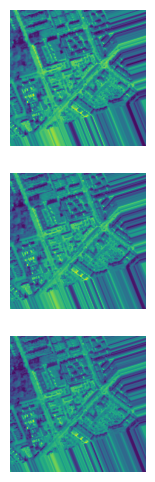

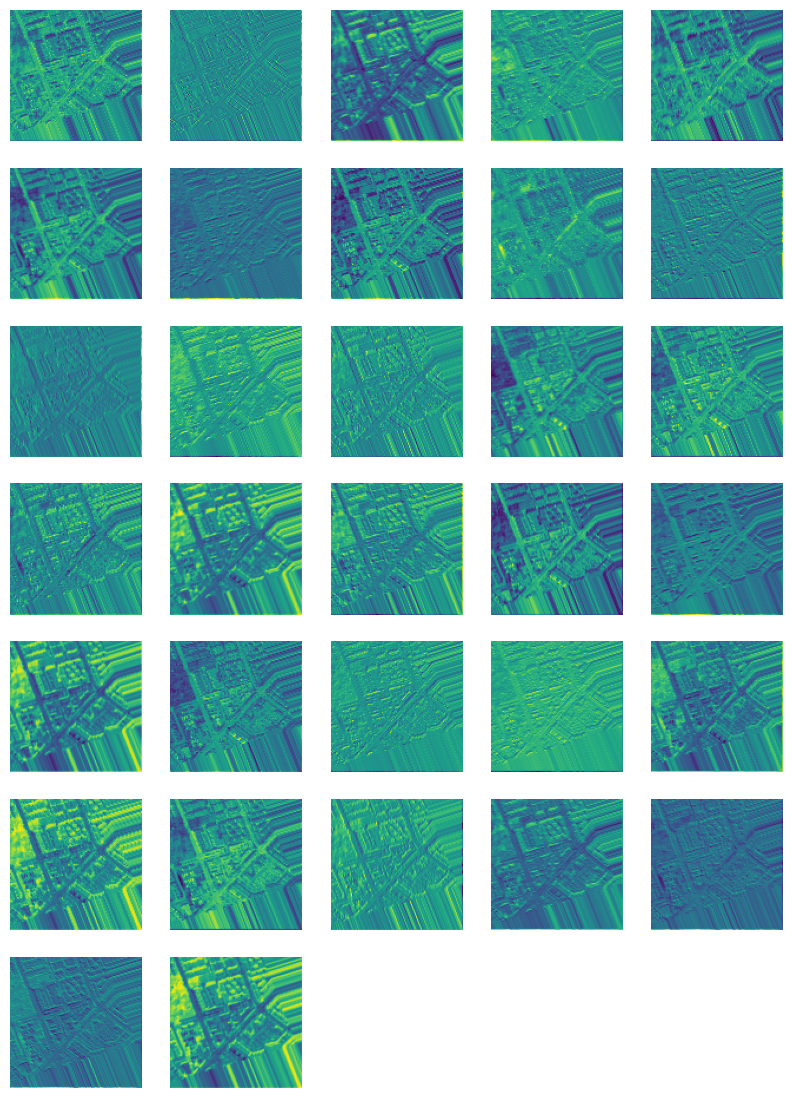

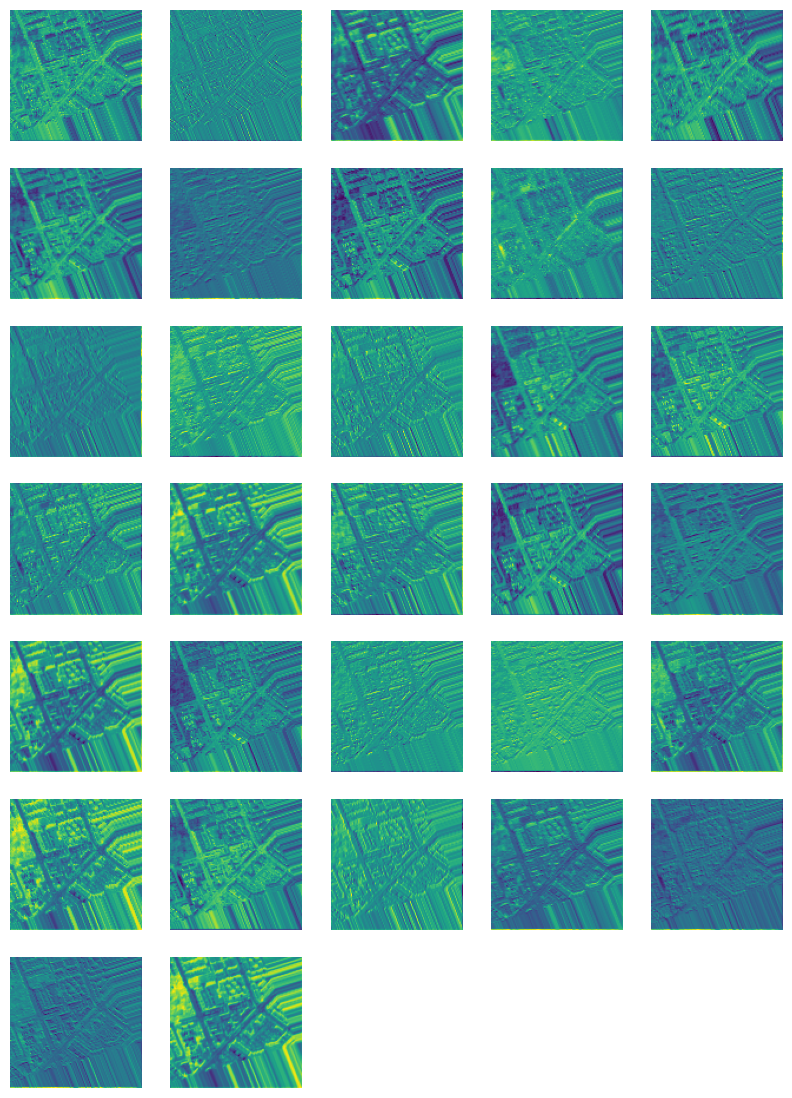

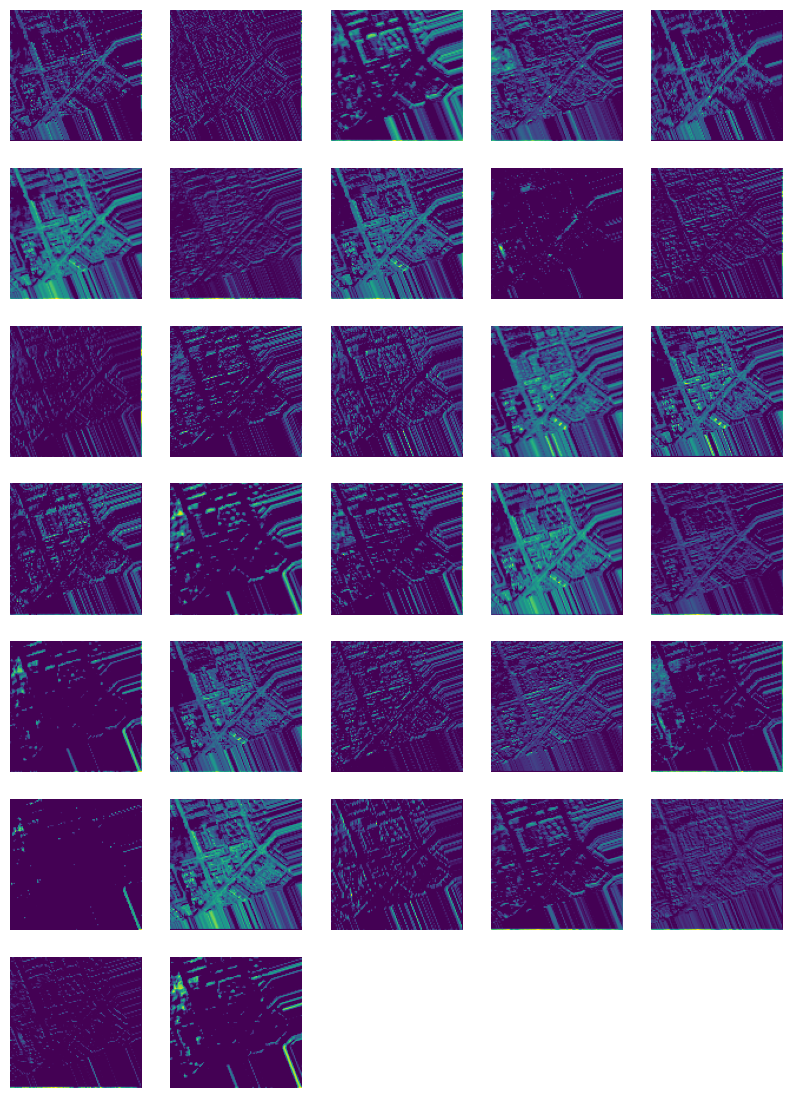

In [11]:
#  Feature Maps Visualization
def visualize_feature_maps(base_model, sample_image, num_layers=4):
    # Extract outputs of the first few layers
    layer_outputs = [layer.output for layer in base_model.layers[:num_layers]]
    activation_model = Model(inputs=base_model.input, outputs=layer_outputs)
    activations = activation_model.predict(sample_image)

    # Plot the activations of the first few layers
    for layer_activation in activations:
        num_features = layer_activation.shape[-1]  # Number of features in the feature map
        size = layer_activation.shape[1]  # Feature map shape (1, size, size, num_features)
        
        # Determine the number of columns and rows for the subplot grid
        n_cols = int(np.sqrt(num_features))
        n_rows = int(np.ceil(num_features / n_cols))

        plt.figure(figsize=(n_cols * 2, n_rows * 2))
        for i in range(num_features):
            plt.subplot(n_rows, n_cols, i + 1)
            plt.imshow(layer_activation[0, :, :, i], cmap='viridis')
            plt.axis('off')
        plt.show()

# Get a sample image from the training set
sample_image, _ = next(train_generator)
visualize_feature_maps(model, sample_image[0:1])